Matplotlib is building the font cache; this may take a moment.


=== Evaluation Metrics Summary ===

K-Means:
Silhouette Coefficient: 0.6603
BCubed - Precision: 0.7537, Recall: 0.7272, F1-Score: 0.7402

DBSCAN:
Silhouette Coefficient (non-noise): 0.8632
BCubed - Precision: 0.7475, Recall: 0.9322, F1-Score: 0.8297


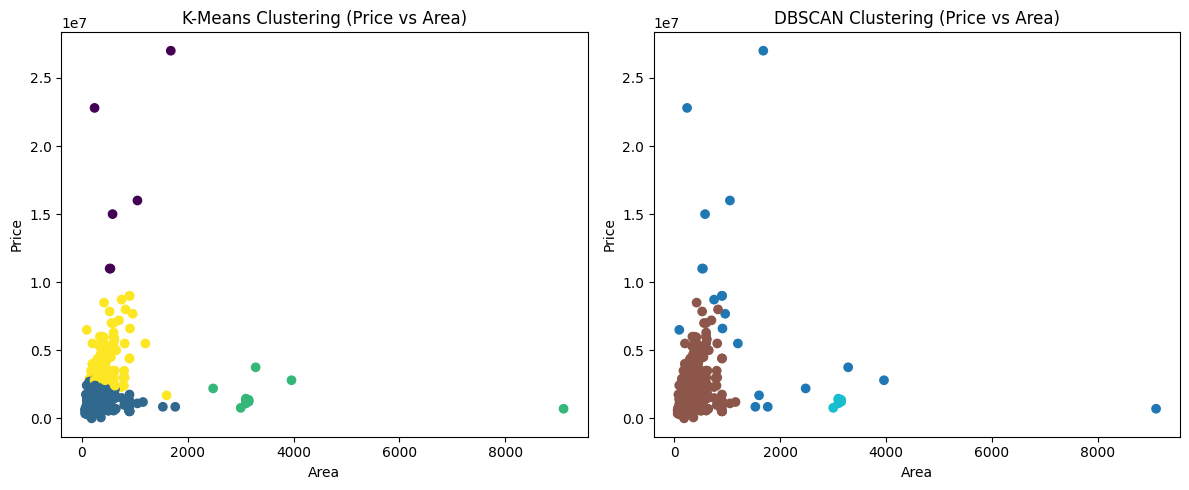


📍 توصيات K-Means:
    Property Type Location  District  Bedrooms  Bathrooms  Original_Area  \
0            فیلا     جنوب       بدر         6          6            300   
9            فیلا      غرب  العريجاء         3          4            312   
470          فیلا      غرب      طويق         7          5            300   
352           دور      شرق  القادسية         4          5            300   
101          فیلا     جنوب      طيبة         8          5            278   

     Original_Price                   Agency_Name  
0            980000  مؤسسة غزالة للخدمات العقارية  
9           1000000   شركة أختصاصي الأول للعقارات  
470         1050000         مكتب الاحمدي للعقارات  
352          900000          سكن المعالي للعقارات  
101          970000    مكتب العقد الذهبي للعقارات  

📍توصيات DBSCAN:
    Property Type Location  District  Bedrooms  Bathrooms  Original_Area  \
0            فیلا     جنوب       بدر         6          6            300   
9            فیلا      غرب  العريجاء       

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# ----------------------------
# 1. Load and Prepare the Data
# ----------------------------
file_path = "../Dataset/cleaned_dataset.csv"
df = pd.read_csv(file_path)
features = ["Area", "Price"]
df_clean = df[features].dropna()

# Preserve original values for display
df_display = df.copy()
df_display["Original_Area"] = df_display["Area"]
df_display["Original_Price"] = df_display["Price"]

# ----------------------------
# 2. Scale the Data
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

# ----------------------------
# 3. K-Means Clustering
# ----------------------------
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df_clean["KMeans_Cluster"] = kmeans_labels

silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)

# ----------------------------
# 4. DBSCAN Clustering
# ----------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df_clean["DBSCAN_Cluster"] = dbscan_labels

valid_mask = dbscan_labels != -1
if valid_mask.sum() > 1 and len(set(dbscan_labels[valid_mask])) > 1:
    silhouette_dbscan = silhouette_score(X_scaled[valid_mask], dbscan_labels[valid_mask])
else:
    silhouette_dbscan = None

# ----------------------------
# 5. BCubed Metrics Functions
# ----------------------------
def bcubed_metrics(true_labels, predicted_labels):
    n = len(true_labels)
    precisions, recalls = [], []
    for i in range(n):
        same_cluster = (predicted_labels == predicted_labels[i])
        same_true = (true_labels == true_labels[i])
        intersection = np.sum(same_cluster & same_true)
        precision_i = intersection / np.sum(same_cluster) if np.sum(same_cluster) > 0 else 0
        recall_i = intersection / np.sum(same_true) if np.sum(same_true) > 0 else 0
        precisions.append(precision_i)
        recalls.append(recall_i)
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

# Assign proxy similarity labels based on closeness

def assign_similarity_labels(df):
    df = df.copy()
    df["Similarity_Label"] = 0
    for i, row in df.iterrows():
        area, price = row["Area"], row["Price"]
        distances = np.sqrt((df["Area"] - area)**2 + (df["Price"] - price)**2)
        closest_indices = distances.nsmallest(3).index
        df.loc[closest_indices, "Similarity_Label"] = 1
    return df

# Generate proxy labels and evaluate BCubed

df_sim = assign_similarity_labels(df_clean)
true_labels = df_sim["Similarity_Label"].values

precision_k, recall_k, f1_k = bcubed_metrics(true_labels, kmeans_labels)
precision_d, recall_d, f1_d = bcubed_metrics(true_labels, dbscan_labels)

# ----------------------------
# 6. Results Summary
# ----------------------------
print("=== Evaluation Metrics Summary ===")
print("\nK-Means:")
print(f"Silhouette Coefficient: {silhouette_kmeans:.4f}")
print(f"BCubed - Precision: {precision_k:.4f}, Recall: {recall_k:.4f}, F1-Score: {f1_k:.4f}")

print("\nDBSCAN:")
if silhouette_dbscan is not None:
    print(f"Silhouette Coefficient (non-noise): {silhouette_dbscan:.4f}")
else:
    print("Silhouette Coefficient: ❌Not computed — only one cluster or all points marked as noise.")
print(f"BCubed - Precision: {precision_d:.4f}, Recall: {recall_d:.4f}, F1-Score: {f1_d:.4f}")

# ----------------------------
# 7. Visualizations
# ----------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("K-Means Clustering (Price vs Area)")
plt.xlabel("Area")
plt.ylabel("Price")
plt.scatter(df_clean["Area"], df_clean["Price"], c=kmeans_labels, cmap='viridis')

plt.subplot(1, 2, 2)
plt.title("DBSCAN Clustering (Price vs Area)")
plt.xlabel("Area")
plt.ylabel("Price")
plt.scatter(df_clean["Area"], df_clean["Price"], c=dbscan_labels, cmap='tab10')

plt.tight_layout()
plt.show()

# ----------------------------
# 8. Recommendations
# ----------------------------
def recommend_properties_kmeans(price_input, area_input, top_n=5):
    input_df = pd.DataFrame([[area_input, price_input]], columns=["Area", "Price"])
    input_scaled = scaler.transform(input_df)
    input_cluster = kmeans.predict(input_scaled)[0]
    cluster_indices = df_clean[df_clean["KMeans_Cluster"] == input_cluster].index
    cluster_data = df_display.loc[cluster_indices].copy()
    X_cluster = X_scaled[cluster_indices]
    distances = np.linalg.norm(X_cluster - input_scaled, axis=1)
    cluster_data["Distance"] = distances
    recommended = cluster_data.sort_values("Distance").head(top_n)
    print("\n📍 توصيات K-Means:")
    print(recommended[["Property Type", "Location", "District", "Bedrooms", "Bathrooms", "Original_Area", "Original_Price", "Agency_Name"]])


def recommend_properties_dbscan(price_input, area_input, top_n=5):
    input_df = pd.DataFrame([[area_input, price_input]], columns=["Area", "Price"])
    input_scaled = scaler.transform(input_df)
    distances = np.linalg.norm(X_scaled - input_scaled, axis=1)
    nearest_index = np.argmin(distances)
    nearest_cluster = dbscan_labels[nearest_index]

    if nearest_cluster == -1:
        print("⚠(Noise).")
        nearest_indices = np.argsort(distances)[:top_n]
        recommended = df_display.iloc[nearest_indices].copy()
    else:
        cluster_indices = np.where(dbscan_labels == nearest_cluster)[0]
        cluster_distances = distances[cluster_indices]
        nearest_indices = cluster_indices[np.argsort(cluster_distances)[:top_n]]
        recommended = df_display.iloc[nearest_indices].copy()

    print("\n📍توصيات DBSCAN:")
    print(recommended[["Property Type", "Location", "District", "Bedrooms", "Bathrooms", "Original_Area", "Original_Price", "Agency_Name"]])

# ----------------------------
# 9. Run Example Recommendations
# ----------------------------
price_input = 980000
area_input = 300
recommend_properties_kmeans(price_input, area_input)
recommend_properties_dbscan(price_input, area_input)

